In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#!pip install apache-log-parser
import apache_log_parser
%matplotlib inline

### Load and parse the data

本案例参考 Nikolay Koldunov（koldunovn@gmail.com）文章完成

我们使用[apache-log-parser](https://github.com/rory/apache-log-parser)进行apalce log分析。log解析前我们需要了解对应的网站的Apahce log的配置。 这里我们已经知道待分析网站的log格式为:  
    
    format = r'%V %h  %l %u %t \"%r\" %>s %b \"%{Referer}i\" \"%{User-Agent}i\" %T'
    
对应的各字段代表内容如下：(参考[stackoverflow](http://stackoverflow.com/questions/9234699/understanding-apache-access-log)):
        
    %V  - 根据 UseCanonicalName 设置的服务器名字
    %h  - 远程主机（客户端 IP）
    %l  - identity of the user determined by identd (not usually used since not reliable)
    %u  - 由 HTTP authentication 决定的 user name
    %t  - 服务器完成处理这个请求的时间
    %r  - 来自客户端的请求行。 （"GET / HTTP/1.0"）
    %>s - 服务器端返回给客户端的状态码（200， 404 等等。）
    %b  - 响应给客户端的响应报文大小 （in bytes）
    \"%{Referer}i\"  - Referer is the page that linked to this URL.
    \"%{User-Agent}i\"  - the browser identification string
    %T  - Apache 请求时间
    

In [3]:
fformat = '%V %h %l %u %t \"%r\" %>s %b \"%{Referer}i\" \"%{User-Agent}i\" %T'

创建解析器

In [4]:
p = apache_log_parser.make_parser(fformat)

比如：
        
        koldunov.net 85.26.235.202 - - [16/Mar/2013:00:19:43 +0400] "GET /?p=364 HTTP/1.0" 200 65237 "http://koldunov.net/?p=364" "Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11" 0


In [5]:
sample_string = 'koldunov.net 85.26.235.202 - - [16/Mar/2013:00:19:43 +0400] "GET /?p=364 HTTP/1.0" 200 65237 "http://koldunov.net/?p=364" "Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11" 0'

In [7]:
data = p(sample_string)

In [8]:
data

{'remote_host': '85.26.235.202',
 'remote_logname': '-',
 'remote_user': '-',
 'request_first_line': 'GET /?p=364 HTTP/1.0',
 'request_header_referer': 'http://koldunov.net/?p=364',
 'request_header_user_agent': 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
 'request_header_user_agent__browser__family': 'Chrome',
 'request_header_user_agent__browser__version_string': '23.0.1271',
 'request_header_user_agent__is_mobile': False,
 'request_header_user_agent__os__family': 'Windows XP',
 'request_header_user_agent__os__version_string': '',
 'request_http_ver': '1.0',
 'request_method': 'GET',
 'request_url': '/?p=364',
 'request_url_fragment': '',
 'request_url_hostname': None,
 'request_url_netloc': '',
 'request_url_password': None,
 'request_url_path': '/',
 'request_url_port': None,
 'request_url_query': 'p=364',
 'request_url_query_dict': {'p': ['364']},
 'request_url_query_list': [('p', '364')],
 'request_url_query_simple_dict

In [10]:
log = open('../data/apache_access_log').readlines()

解析每一行，并创建dict list

In [11]:
log_list = []
for line in log:
       try:
          data = p(line)
       except:
          sys.stderr.write("Unable to parse %s" % line)
       data['time_received'] = data['time_received'][1:12]+' '+data['time_received'][13:21]+' '+data['time_received'][22:27]
      
       log_list.append(data)


### 准备网站日志数据

把字典转化为DataFrame

In [12]:
df = pd.DataFrame(log_list)

In [13]:
df.columns

Index(['remote_host', 'remote_logname', 'remote_user', 'request_first_line',
       'request_header_referer', 'request_header_user_agent',
       'request_header_user_agent__browser__family',
       'request_header_user_agent__browser__version_string',
       'request_header_user_agent__is_mobile',
       'request_header_user_agent__os__family',
       'request_header_user_agent__os__version_string', 'request_http_ver',
       'request_method', 'request_url', 'request_url_fragment',
       'request_url_hostname', 'request_url_netloc', 'request_url_password',
       'request_url_path', 'request_url_port', 'request_url_query',
       'request_url_query_dict', 'request_url_query_list',
       'request_url_query_simple_dict', 'request_url_scheme',
       'request_url_username', 'response_bytes_clf', 'server_name2', 'status',
       'time_received', 'time_received_datetimeobj', 'time_received_isoformat',
       'time_received_tz_datetimeobj', 'time_received_tz_isoformat',
       'time_recei

In [14]:
df=df[['status','response_bytes_clf','remote_host','request_first_line','time_received']]

In [15]:
df.head()

,status,response_bytes_clf,remote_host,request_first_line,time_received
0,200,26126,109.165.31.156,GET /index.php?option=com_content&task=section...,16/Mar/2013 08:00:25 +0400
1,200,10532,109.165.31.156,GET /templates/ja_procyon/css/template_css.css...,16/Mar/2013 08:00:25 +0400
2,200,1853,109.165.31.156,GET /templates/ja_procyon/switcher.js HTTP/1.0,16/Mar/2013 08:00:25 +0400
3,200,37153,109.165.31.156,GET /includes/js/overlib_mini.js HTTP/1.0,16/Mar/2013 08:00:25 +0400
4,200,3978,109.165.31.156,GET /modules/ja_transmenu/transmenuh.css HTTP/1.0,16/Mar/2013 08:00:25 +0400


把time_received变成index，这里使用了pop

In [16]:
df.index = pd.to_datetime(df.pop('time_received'))

In [18]:
df.head()

,status,response_bytes_clf,remote_host,request_first_line
time_received,,,,
2013-03-16 04:00:25,200,26126,109.165.31.156,GET /index.php?option=com_content&task=section...
2013-03-16 04:00:25,200,10532,109.165.31.156,GET /templates/ja_procyon/css/template_css.css...
2013-03-16 04:00:25,200,1853,109.165.31.156,GET /templates/ja_procyon/switcher.js HTTP/1.0
2013-03-16 04:00:25,200,37153,109.165.31.156,GET /includes/js/overlib_mini.js HTTP/1.0
2013-03-16 04:00:25,200,3978,109.165.31.156,GET /modules/ja_transmenu/transmenuh.css HTTP/1.0


In [19]:
df.info() #status不是int

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6634 entries, 2013-03-16 04:00:25 to 2013-03-16 20:19:30
Data columns (total 4 columns):
status                6634 non-null object
response_bytes_clf    6634 non-null object
remote_host           6634 non-null object
request_first_line    6634 non-null object
dtypes: object(4)
memory usage: 259.1+ KB


In [20]:
df.loc[:,'status'] = df['status'].astype('int')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6634 entries, 2013-03-16 04:00:25 to 2013-03-16 20:19:30
Data columns (total 4 columns):
status                6634 non-null int32
response_bytes_clf    6634 non-null object
remote_host           6634 non-null object
request_first_line    6634 non-null object
dtypes: int32(1), object(3)
memory usage: 233.2+ KB


而* 	response_bytes_clf* 列有些数据包含字符串 '-'，我们无法直接使用*astype*:

In [27]:
df['response_bytes_clf'][93]

nan

将'-'转换成NaN，同时单位换算为M

In [24]:
def dash2nan(x):
    if x == '-':
        x = np.nan
    else:
        x = float(x)/1048576.
    
    return x

In [25]:
df['response_bytes_clf'] = df['response_bytes_clf'].apply(dash2nan)

In [38]:
df.head()


,status,response_bytes_clf,remote_host,request_first_line
time_received,,,,
2013-03-16 04:00:25,200,0.024916,109.165.31.156,GET /index.php?option=com_content&task=section...
2013-03-16 04:00:25,200,0.010044,109.165.31.156,GET /templates/ja_procyon/css/template_css.css...
2013-03-16 04:00:25,200,0.001767,109.165.31.156,GET /templates/ja_procyon/switcher.js HTTP/1.0
2013-03-16 04:00:25,200,0.035432,109.165.31.156,GET /includes/js/overlib_mini.js HTTP/1.0
2013-03-16 04:00:25,200,0.003794,109.165.31.156,GET /modules/ja_transmenu/transmenuh.css HTTP/1.0


### 流量分析

根据时间看网站下载流量

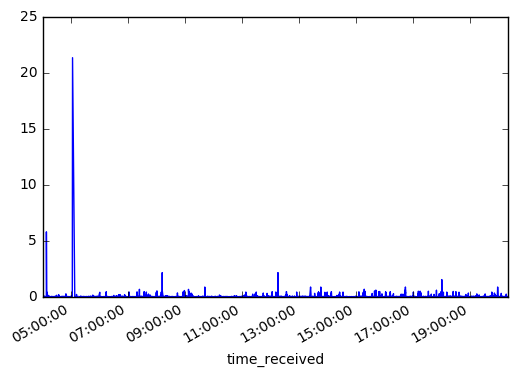

In [20]:
df['response_bytes_clf'].plot()

按照5分钟进行重新采样，统计访问次数

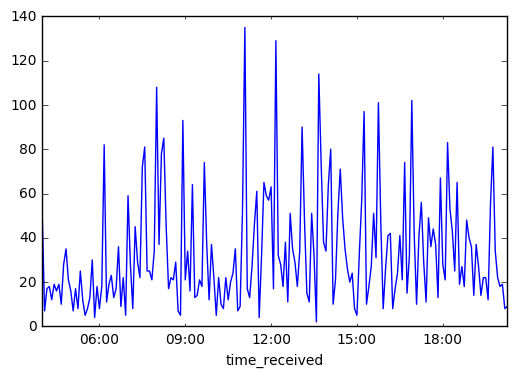

In [29]:
df_s = df['response_bytes_clf'].resample('5t').count()
df_s.plot()

同时统计访问次数以及流量

                     count       sum
time_received                       
2013-03-16 04:00:00     59  6.957677
2013-03-16 04:10:00     35  0.929472
2013-03-16 04:20:00     31  0.771323
2013-03-16 04:30:00     35  0.771191
2013-03-16 04:40:00     38  0.943575


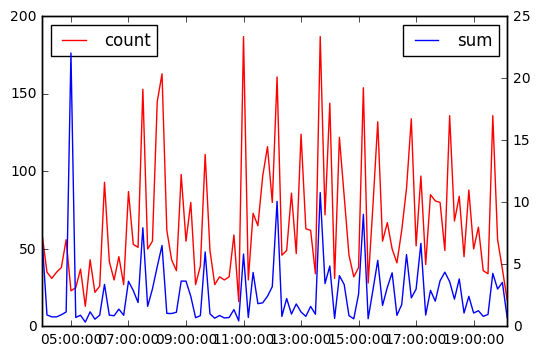

In [40]:
df_b = pd.DataFrame({'count':df['response_bytes_clf'].resample('10t').count(), 'sum':df['response_bytes_clf'].resample('10t').sum()})
print(df_b.head())
ax1 = plt.subplot(111)
ax2 = ax1.twinx()
ax1.plot(df_b['count'],color='r',label='count')
ax1.legend(loc=2)
ax2.plot(df_b['sum'],label='sum')
ax2.legend(loc=0)

In [41]:
df_b.head()

,count,sum
time_received,,
2013-03-16 04:00:00,59,6.957677
2013-03-16 04:10:00,35,0.929472
2013-03-16 04:20:00,31,0.771323
2013-03-16 04:30:00,35,0.771191
2013-03-16 04:40:00,38,0.943575


流量与访问数的关系

In [24]:
df_b.corr()

,count,sum
count,1.000000,0.512629
sum,0.512629,1.000000


考察一下流量高的时间段

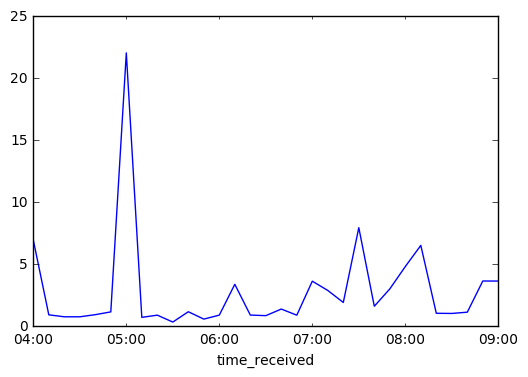

In [25]:
df_b['2013-03-16 2:00':'2013-03-16 9:00']['sum'].plot()

似乎是下载了一本书，一共21M

In [26]:
df[df['response_bytes_clf']>20]

,status,response_bytes_clf,remote_host,request_first_line
time_received,,,,
2013-03-16 05:02:59,200,21.365701,77.50.248.20,GET /books/Bondarenko.pdf HTTP/1.0


通常情况下request大小是多少呢？

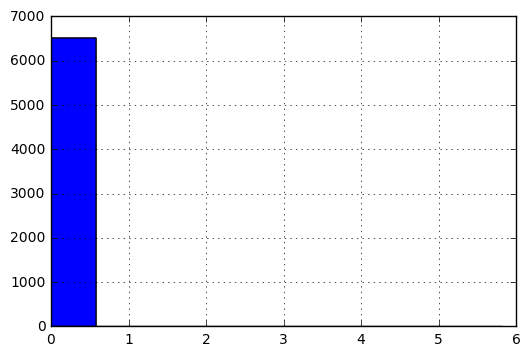

In [42]:
cc = df[df['response_bytes_clf']<20]
cc.response_bytes_clf.hist(bins=10)

大部分小于0.5M

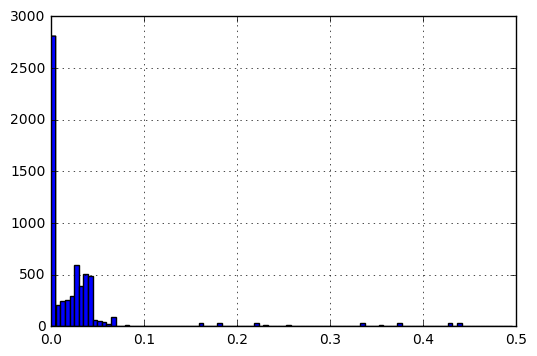

In [43]:
cc = df[df['response_bytes_clf']<0.5]
cc.response_bytes_clf.hist(bins=100)

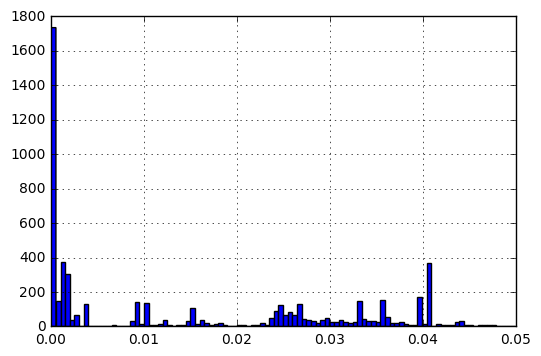

In [44]:
cc = df[(df['response_bytes_clf']>0.0)&(df['response_bytes_clf']<0.05)]
cc.response_bytes_clf.hist(bins=100)

In [46]:
cc = df[(df['response_bytes_clf']>0.2)&(df['response_bytes_clf']<0.3)]
cc.head()

,status,response_bytes_clf,remote_host,request_first_line
time_received,,,,
2013-03-16 04:33:31,200,0.211596,46.227.184.109,GET /mypict/geu.jpg HTTP/1.0
2013-03-16 04:48:57,200,0.280807,199.30.16.15,GET /mypict/gs/gs12.png HTTP/1.0
2013-03-16 05:11:20,200,0.224728,217.69.133.68,GET /images/stories/pdf/Haas2004.pdf HTTP/1.0
2013-03-16 06:13:51,200,0.223101,178.238.18.194,GET /mypict/itpocover.png HTTP/1.0
2013-03-16 06:43:01,200,0.214050,217.69.133.68,GET /images/stories/pdf/9909_059.pdf HTTP/1.0


### 根据服务器返回状态码进行分析

In [47]:
t_span = '2H'
df_404 = df['status'][df['status'] == 404].resample(t_span).count()
df_403 = df['status'][df['status'] == 403].resample(t_span).count()
df_301 = df['status'][df['status'] == 301].resample(t_span).count()
df_304 = df['status'][df['status'] == 304].resample(t_span).count()
df_200 = df['status'][df['status'] == 200].resample(t_span).count()

status_df = pd.DataFrame({'Not Found':df_404, 'Forbidden':df_403, 'Moved Permanently':df_301, 'Not Modified':df_304, 'OK':df_200,})

In [48]:
status_df.head()

,Forbidden,Moved Permanently,Not Found,Not Modified,OK
time_received,,,,,
2013-03-16 04:00:00,22,17,3,4.0,375
2013-03-16 06:00:00,26,76,2,2.0,607
2013-03-16 08:00:00,45,83,2,23.0,780
2013-03-16 10:00:00,29,34,4,2.0,699
2013-03-16 12:00:00,27,94,5,3.0,886


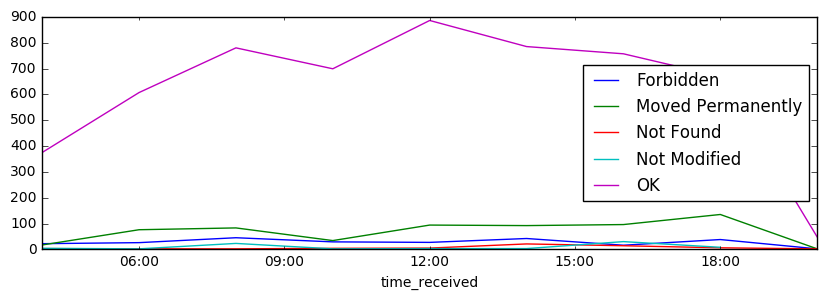

In [33]:
status_df.plot(figsize=(10, 3))

stacked plot

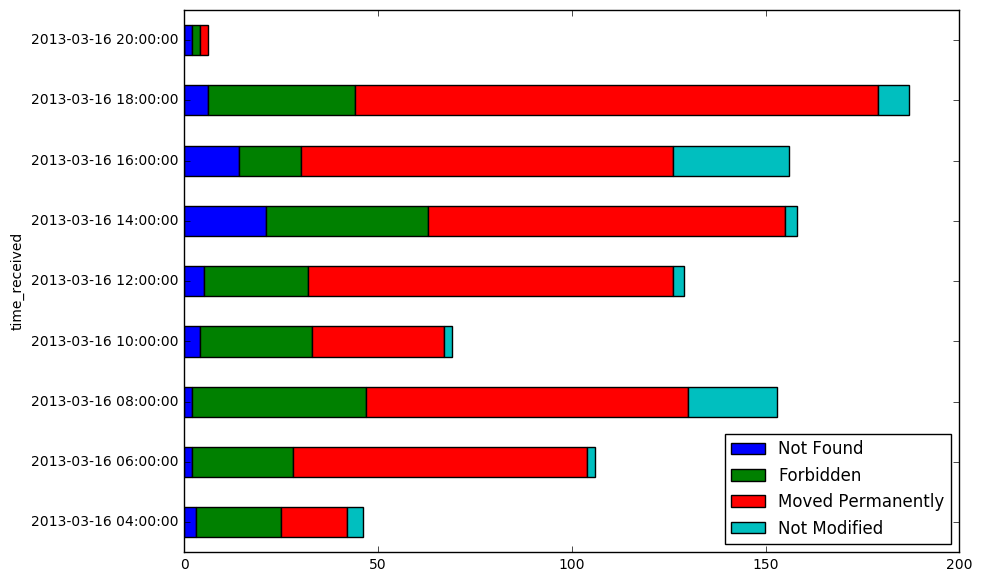

In [34]:
status_df[['Not Found','Forbidden','Moved Permanently','Not Modified']].plot(kind='barh', stacked=True, figsize=(10, 7))

根据*Status*分组

In [49]:
grouped_status = df.groupby('status')

In [50]:
grouped_status.head(2)

,status,response_bytes_clf,remote_host,request_first_line
time_received,,,,
2013-03-16 04:00:25,200,0.024916,109.165.31.156,GET /index.php?option=com_content&task=section...
2013-03-16 04:00:25,200,0.010044,109.165.31.156,GET /templates/ja_procyon/css/template_css.css...
2013-03-16 04:04:23,403,0.001054,5.79.199.116,GET /forum/download/file.php?avatar=156.gif HT...
2013-03-16 04:04:23,403,0.001054,5.79.199.116,GET /forum/download/file.php?avatar=216.jpg HT...
2013-03-16 04:04:25,404,0.001063,5.79.199.116,GET /apple-touch-icon-precomposed.png HTTP/1.0
2013-03-16 04:04:26,404,0.001063,5.79.199.116,GET /apple-touch-icon.png HTTP/1.0
2013-03-16 04:13:08,301,0.000232,38.100.21.63,GET /forum HTTP/1.0
2013-03-16 04:13:09,400,0.000999,38.100.21.63,GET /.. HTTP/1.0
2013-03-16 04:13:09,301,0.000234,38.100.21.63,GET /podcast HTTP/1.0


每组大小

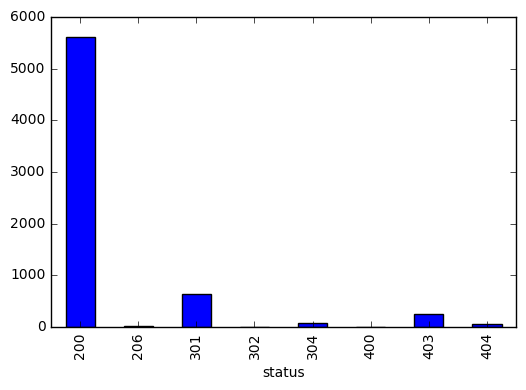

In [37]:
grouped_status.size().plot(kind='bar')

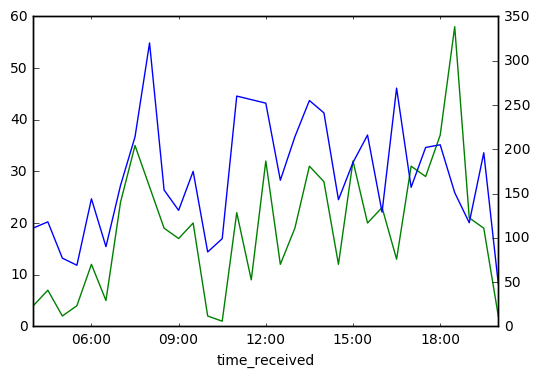

In [38]:
t_span = '30t'
grouped_status.get_group(301)['status'].resample(t_span).count().plot(color='g', label='301')
grouped_status.get_group(200)['status'].resample(t_span).count().plot(color='b', secondary_y=True, label='200')

### IPs

根据IP地址来源统计

In [55]:
ips = df.groupby('remote_host').size()

In [65]:
ips.head()

remote_host
100.44.124.8       26
108.171.252.242    24
109.165.31.156     12
109.171.109.164     4
109.191.82.110     14
dtype: int64

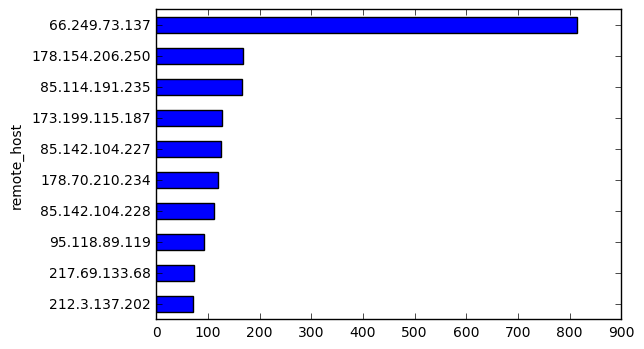

In [57]:
ips_sorted=ips.sort_values()
ips_sorted[-10:].plot(kind='barh')

In [58]:
ips_fd = pd.DataFrame({'Number of requests':ips_sorted[-10:]})
ips_fd = ips_fd.sort_values(by='Number of requests',  ascending=False)
ips_fd

,Number of requests
remote_host,
66.249.73.137,814
178.154.206.250,168
85.114.191.235,165
173.199.115.187,127
85.142.104.227,126
178.70.210.234,120
85.142.104.228,111
95.118.89.119,93
217.69.133.68,74


按照*IP* 以及 *Status*分组

In [59]:
ips_status = df.groupby(['remote_host', 'status']).size()

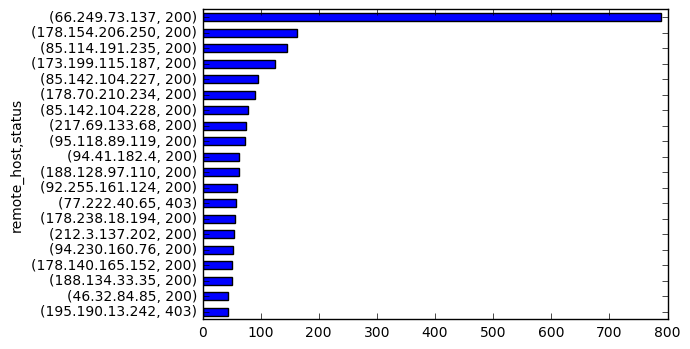

In [61]:
ips_status.sort_values()[-20:].plot(kind='barh')

### 地理信息

利用[pygeoip](https://github.com/appliedsec/pygeoip)可以根据IP获取对应地理信息。这里我们需要[下载 ](http://dev.maxmind.com/geoip/geolite)对应文件

In [62]:
#!pip install pygeoip
import pygeoip
gi = pygeoip.GeoIP('../data/GeoLiteCity.dat', pygeoip.MEMORY_CACHE)

In [63]:
gi.record_by_addr?

In [64]:
ipcon = gi.record_by_addr('64.233.161.99')
ipcon

{'area_code': 650,
 'city': 'Mountain View',
 'continent': 'NA',
 'country_code': 'US',
 'country_code3': 'USA',
 'country_name': 'United States',
 'dma_code': 807,
 'latitude': 37.41919999999999,
 'longitude': -122.0574,
 'metro_code': 'San Francisco, CA',
 'postal_code': '94043',
 'region_code': 'CA',
 'time_zone': 'America/Los_Angeles'}

In [69]:
ipcon = []
i=0
for iip in ips.index:
    rres = gi.record_by_addr(iip)
    if rres==None:
        print(iip)
        continue
    rres['Number'] = ips[iip]
    #delete some fields we don't need
    del rres['area_code']
    del rres['dma_code']
    del rres['metro_code']
    del rres['postal_code']
    del rres['region_code']
    del rres['time_zone']
    del rres['country_code']
    
    ipcon.append(rres)
    

91.224.246.183


In [70]:
#ips['91.224.246.183']
ips.drop('91.224.246.183',inplace=True)

In [71]:
reg = pd.DataFrame(ipcon, index = ips.index)
reg.head()

,Number,city,continent,country_code3,country_name,latitude,longitude
remote_host,,,,,,,
100.44.124.8,26,None,NA,USA,United States,37.7510,-97.8220
108.171.252.242,24,Walnut,NA,USA,United States,34.0115,-117.8535
109.165.31.156,12,Rostov,EU,RUS,Russian Federation,47.2364,39.7139
109.171.109.164,4,Novosibirsk,EU,RUS,Russian Federation,55.0415,82.9346
109.191.82.110,14,Chelyabinsk,EU,RUS,Russian Federation,55.1544,61.4297


根据国家分组

In [72]:
country = reg.groupby('country_code3')

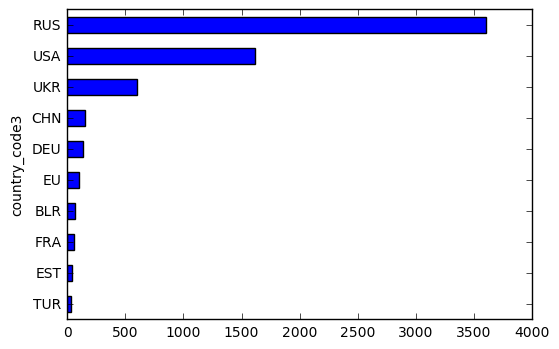

In [86]:
ff = country.Number.agg('sum').copy()
ff.sort_values(inplace=True )
ff[-10:].plot(kind='barh')

显然这是一个俄罗斯的网站

Group by city:

In [74]:
city = reg.groupby('city')

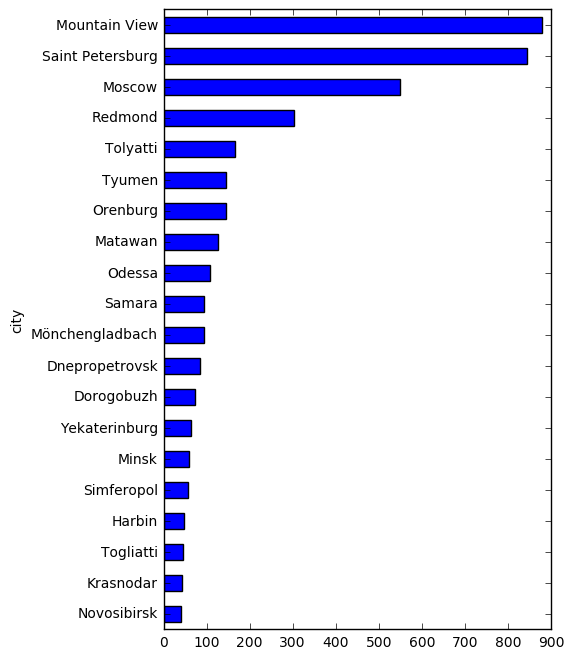

In [75]:
ff = city.Number.agg('sum').copy()
ff.sort_values(inplace=True )
ff[-20:].plot(kind='barh', figsize=(5,8))

In [3]:
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm

In [56]:
m = Basemap(projection='robin',lon_0=0,resolution='c')
x, y = m(reg['longitude'],reg['latitude'])

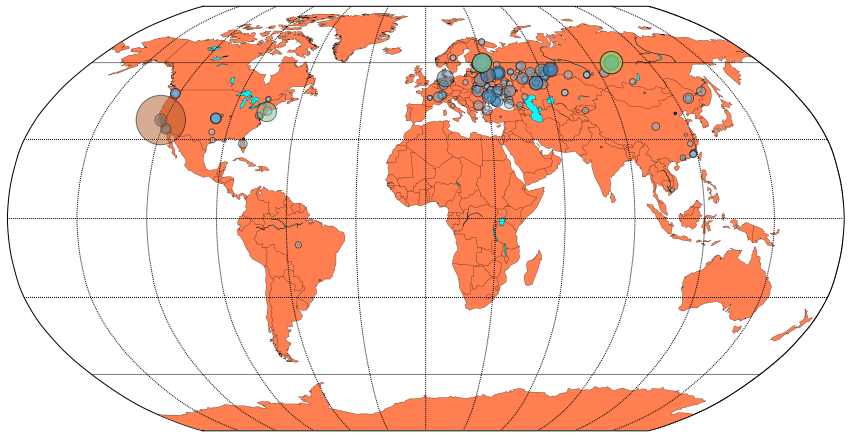

In [67]:
figure(figsize=(15,15))
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)

m.fillcontinents(color='coral',lake_color='aqua')
m.drawmapboundary(fill_color='white')
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
m.scatter(x,y,s=reg['Number']*3,c=reg['Number']/5,marker='o',zorder=4, cmap=cm.Paired,alpha=0.5)

欧洲

In [68]:
m = Basemap(projection='cyl',llcrnrlat=35,urcrnrlat=72,\
            llcrnrlon=-10,urcrnrlon=50,resolution='l')
x, y = m(reg['longitude'],reg['latitude'])

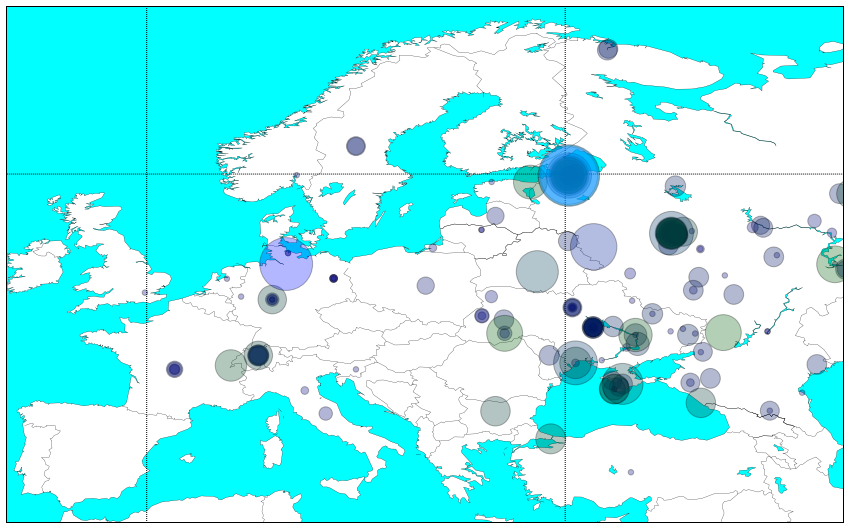

In [69]:
figure(figsize=(15,15))
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)
m.fillcontinents(color='white',lake_color='aqua')
m.drawmapboundary(fill_color='aqua')
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
m.scatter(x,y,s=reg['Number']*30,c=reg['Number'],marker='o',zorder=4, cmap=cm.gist_ncar ,alpha=0.3)


### 可能的垃圾用户？（根据request来进行）

例如短时间不断发post?

In [70]:
def gmet(x):
    x = x.split()
    return x[0]

We apply this little function to the *Request* column and create new *Method* column:

In [71]:
df['Method'] = df.Request.apply(gmet)

Group by *Method* and *IP*:

In [72]:
met = df.groupby(['Method', 'IP']).size()

In [73]:
met.head

<bound method Series.head of Method  IP             
GET     100.44.124.8       26
        108.171.252.242    23
        109.165.31.156     12
        109.171.109.164     4
        109.191.82.110     14
        109.200.149.88     56
        109.205.252.77     32
        109.225.55.49      13
        109.226.101.186    45
        109.230.128.168     9
        109.230.128.169    13
        109.230.132.244     2
        109.87.146.37       4
        109.87.148.141     13
        111.73.45.49       10
...
POST    46.191.247.15      5
        46.29.255.194      5
        5.164.227.102      6
        66.23.234.10      10
        77.222.40.65      58
        78.30.212.183      4
        81.200.28.126      1
        85.114.191.235     2
        85.142.104.227     1
        91.207.4.78        5
        94.190.190.121     5
        94.45.180.57       5
        95.105.29.56       5
        95.27.28.213       5
        95.84.137.56       6
Length: 470>

In [74]:
post = met['POST'].copy()
post.sort()

Plot the top 10 IPs that use POST method:

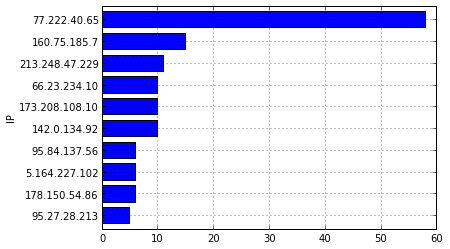

In [75]:
post[-10:].plot(kind='barh')

In [76]:
post[-5:]

IP
173.208.108.10    10
66.23.234.10      10
213.248.47.229    11
160.75.185.7      15
77.222.40.65      58

排名第一的

In [77]:
df[df.IP =='77.222.40.65'][0:5]

,Status,b,IP,Request,Method
Time,,,,,
2013-03-16 08:28:43,403,0.001054,77.222.40.65,POST /podcast/wp-cron.php?doing_wp_cron=136340...,POST
2013-03-16 08:45:08,403,0.001054,77.222.40.65,POST /podcast/wp-cron.php?doing_wp_cron=136340...,POST
2013-03-16 09:19:52,403,0.001054,77.222.40.65,POST /podcast/wp-cron.php?doing_wp_cron=136341...,POST
2013-03-16 09:36:26,403,0.001054,77.222.40.65,POST /podcast/wp-cron.php?doing_wp_cron=136341...,POST
2013-03-16 09:40:22,403,0.001054,77.222.40.65,POST /podcast/wp-cron.php?doing_wp_cron=136341...,POST


wordpress cron job，是自己的网站地址

排名第二

In [78]:
df[df.IP =='160.75.185.7'][0:10]

,Status,b,IP,Request,Method
Time,,,,,
2013-03-16 17:27:12,200,0.002224,160.75.185.7,GET /administrator/index.php HTTP/1.0,GET
2013-03-16 17:27:12,200,0.002224,160.75.185.7,GET /administrator/index.php HTTP/1.0,GET
2013-03-16 17:27:12,200,0.002224,160.75.185.7,GET /administrator/index.php HTTP/1.0,GET
2013-03-16 17:27:12,200,0.002224,160.75.185.7,GET /administrator/index.php HTTP/1.0,GET
2013-03-16 17:27:12,200,0.002224,160.75.185.7,GET /administrator/index.php HTTP/1.0,GET
2013-03-16 17:27:12,200,0.002224,160.75.185.7,POST /administrator/index.php HTTP/1.0,POST
2013-03-16 17:27:12,200,0.002224,160.75.185.7,POST /administrator/index.php HTTP/1.0,POST
2013-03-16 17:27:12,200,0.002224,160.75.185.7,GET /administrator/index.php HTTP/1.0,GET
2013-03-16 17:27:12,200,0.002224,160.75.185.7,POST /administrator/index.php HTTP/1.0,POST


可疑？ 访问admin, block?

排名第三

In [79]:
df[df.IP =='213.248.47.229'][0:10]

,Status,b,IP,Request,Method
Time,,,,,
2013-03-16 11:00:34,200,0.012539,213.248.47.229,GET /forum/ucp.php?mode=register&sid=8203c4843...,GET
2013-03-16 11:00:34,200,0.026559,213.248.47.229,GET /forum/index.php HTTP/1.0,GET
2013-03-16 11:00:34,200,0.012011,213.248.47.229,GET /forum/ucp.php?mode=register&sid=c78851b8f...,GET
2013-03-16 11:00:39,200,0.016414,213.248.47.229,POST /forum/ucp.php?mode=register&sid=12986e06...,POST
2013-03-16 11:00:39,200,0.016414,213.248.47.229,POST /forum/ucp.php?mode=register HTTP/1.0,POST
2013-03-16 11:00:44,200,0.015024,213.248.47.229,POST /forum/ucp.php?mode=register HTTP/1.0,POST
2013-03-16 11:00:45,200,0.015028,213.248.47.229,POST /forum/ucp.php?mode=register HTTP/1.0,POST
2013-03-16 11:00:49,200,0.015024,213.248.47.229,POST /forum/ucp.php?mode=register HTTP/1.0,POST
2013-03-16 11:00:50,200,0.015028,213.248.47.229,POST /forum/ucp.php?mode=register HTTP/1.0,POST


每隔几秒就访问？攻击？